### Problem Statement

For starters let us write an agent to solve a simple optimization problem.
1. Data Generator: Write a piece of code which produces our ground truth data as
y=f(x) where f(x) = −0.2 + 0.4 ∗ x and x should be in the range [-1,1]. Produce a
plot of f(x).
2. Function: The function we’d like to fit is f(x; α, β) = α + β ∗ x Write a piece of
code which produces ŷ = f(x; α, β). Produce a plot for all parameters equal to one.
3. Discretized Space: Let also be α and β be in the range [-1,1]. Their values should
be discretized with stepsize 0.2. Plot this space as squares in a plane where each
discrete pair is denoted by a dot in the middle of one of the squares (should be 64
squares in the end).
4. Rewards: Use the RMSE value at a given point to come up with rewards for this
space, i.e lower RMSE should give more reward then higher RMSE. Add the
Rewards to your plot from 3.
5. Q Learning: Write an agent which is able to walk this discrete space to find the
parameters of the true data generator.

In [75]:

# import random
# import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib nbagg  

# core imports
import os
import sys
import random
import numpy as np

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
# local imports
from autonetwork.environments.single_parameter import TwoParaEnv
from autonetwork.agents.qlearning_agent import QLearningAgent
from autonetwork.simulation import Run, Exploration



interactive = True



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
def data_generator(input_data):
    """
    Generate ground truth data (y) based on
    y=f(x) where f(x) = −0.2 + 0.4 ∗ x
    """
    return -0.2 + 0.4 * input_data

def fit_function(x, alpha, beta):
    """
    Return predicted value (y_bar)
    """
    return alpha + beta * x

def discrete_parameter_space(input_range, step_size=0.2):
    """
    We have alpha and beta parameters for the model.
    We are creating discrete parameter space for the modeling purpose.
    """
    return np.arange(input_range[0]+step_size, input_range[1], step_size)

def rmse_func(targets, predictions):
    """
    it calculate the root mean square value
    """
    return np.sqrt(np.mean((predictions-targets)**2))

def continuous_reward_func(current_input):
    """
    continuous rewards based on rmse value)
    """
    
    # making sure higher rmse gets lower reward
    if current_input == 0:
        return 10
    return 1/current_input
    

### 1. Generate Ground Truth

In [59]:
input_range = (-1, 1)
data_length = 20
input_data = np.linspace(input_range[0], input_range[1], data_length)
ground_truth = data_generator(input_data)

In [60]:
ground_truth

array([-0.6       , -0.55789474, -0.51578947, -0.47368421, -0.43157895,
       -0.38947368, -0.34736842, -0.30526316, -0.26315789, -0.22105263,
       -0.17894737, -0.13684211, -0.09473684, -0.05263158, -0.01052632,
        0.03157895,  0.07368421,  0.11578947,  0.15789474,  0.2       ])

### 2. Plot Grouth Truth

<IPython.core.display.Javascript object>


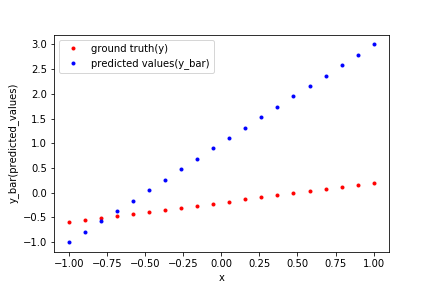

In [61]:
index = np.linspace(input_range[0], input_range[1], data_length)
plt.plot(index, ground_truth, 'r.', label='ground truth(y)') # x
plt.legend(loc="upper left")
plt.xlabel('x', fontsize=16)
plt.ylabel('y(ground truth)', fontsize=16)
plt.show()

### 3. Fit model (f(x; α, β) = α + β ∗ x) with α, β = 1

In [62]:
alpha = 1
beta = 2
fitted_values = fit_function(input_data, alpha, beta)

In [63]:
plt.plot(index, fitted_values, 'b.', label='predicted values(y_bar)') # x

plt.legend(loc="upper left")
plt.xlabel('x', fontsize=10)
plt.ylabel('y_bar(predicted_values)', fontsize=10)
plt.show()

### 4. Discretize the parameter space and create square maze

In [64]:
discrete_alphas = discrete_parameter_space(input_range)
discrete_betas = discrete_parameter_space(input_range)

In [65]:
discrete_alphas, discrete_betas

(array([-8.00000000e-01, -6.00000000e-01, -4.00000000e-01, -2.00000000e-01,
        -2.22044605e-16,  2.00000000e-01,  4.00000000e-01,  6.00000000e-01,
         8.00000000e-01]),
 array([-8.00000000e-01, -6.00000000e-01, -4.00000000e-01, -2.00000000e-01,
        -2.22044605e-16,  2.00000000e-01,  4.00000000e-01,  6.00000000e-01,
         8.00000000e-01]))

<IPython.core.display.Javascript object>


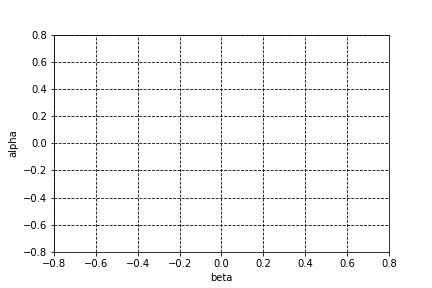

In [66]:
fig, ax = plt.subplots()
ax.set_xlim((-0.8,0.8))
ax.set_ylim((-0.8,0.8))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.grid(b=True, which='major', color='k', linestyle='--')
# fig.savefig('test.png', dpi=600)
# plt.close(fig)
plt.xlabel('beta', fontsize=10)
plt.ylabel('alpha', fontsize=10)
plt.show()

### 5. Plot the rewards on the space based on RMSE value

In [67]:
# apply alpha, beta pair from discrete_alphas, discrete_betas to calculate the rewards
reward_matrix = []
positive_reward_20_spaces = []
positive_reward_10_spaces = []
positive_reward_5_spaces = []
negative_reward_spaces = []
for alpha in discrete_alphas:
    reward_row = []
    for beta in discrete_betas:
        predictions = fit_function(input_data, alpha, beta)
        rmse = rmse_func(ground_truth, predictions)
        reward = continuous_reward_func(rmse)
        if reward == 20:
            positive_reward_20_spaces.append([beta + 0.1, alpha+0.1])
        elif reward == 10:
            positive_reward_10_spaces.append([beta + 0.1, alpha+0.1])
        elif reward == 5:
            positive_reward_5_spaces.append([beta + 0.1, alpha+0.1])
        else:
            negative_reward_spaces.append([beta + 0.1, alpha+0.1])
        reward_row.append(reward)
    
    reward_matrix.append(reward_row)


### 6. Q-learning 

In [68]:
R = np.array(reward_matrix)
R

array([[1.05968460e+00, 1.17167929e+00, 1.29554824e+00, 1.42475069e+00,
        1.54497077e+00, 1.63356644e+00, 1.66666667e+00, 1.63356644e+00,
        1.54497077e+00],
       [1.20339966e+00, 1.37565631e+00, 1.58952689e+00, 1.84858491e+00,
        2.13712604e+00, 2.39225658e+00, 2.50000000e+00, 2.39225658e+00,
        2.13712604e+00],
       [1.32392127e+00, 1.56475353e+00, 1.90419384e+00, 2.40679931e+00,
        3.17905379e+00, 4.27425207e+00, 5.00000000e+00, 4.27425207e+00,
        3.17905379e+00],
       [1.37292412e+00, 1.64750894e+00, 2.05938618e+00, 2.74584824e+00,
        4.11877236e+00, 8.23754471e+00, 3.74508389e+15, 8.23754471e+00,
        4.11877236e+00],
       [1.32392127e+00, 1.56475353e+00, 1.90419384e+00, 2.40679931e+00,
        3.17905379e+00, 4.27425207e+00, 5.00000000e+00, 4.27425207e+00,
        3.17905379e+00],
       [1.20339966e+00, 1.37565631e+00, 1.58952689e+00, 1.84858491e+00,
        2.13712604e+00, 2.39225658e+00, 2.50000000e+00, 2.39225658e+00,
        2.1

<IPython.core.display.Javascript object>


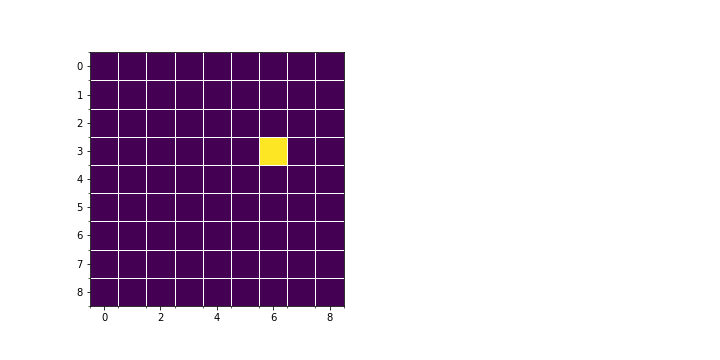

In [69]:
from matplotlib import pyplot as plt
from matplotlib import pylab
import matplotlib.gridspec as gridspec

# rewards table
R = np.array(reward_matrix)
fig3 = pylab.figure(figsize=(10, 5))
gs = gridspec.GridSpec(2, 2)
ax = pylab.subplot(gs[:, 0])
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.imshow(R, interpolation='none', cmap='viridis')

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_xticks(np.arange(-.5, 9, 1), minor=True);
ax.set_yticks(np.arange(-.5, 9, 1), minor=True);
ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
fig3.canvas.draw()

<IPython.core.display.Javascript object>


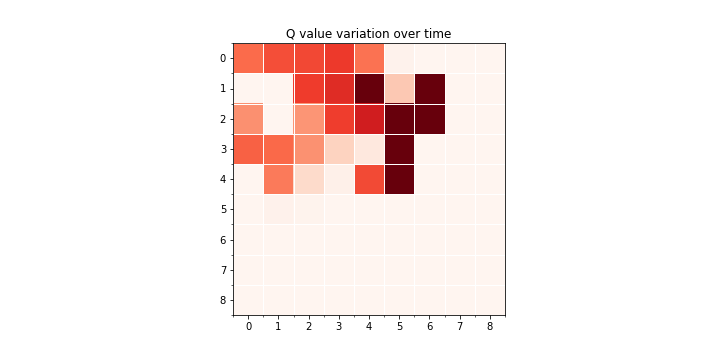

current q table [[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
i am called first


<IPython.core.display.Javascript object>


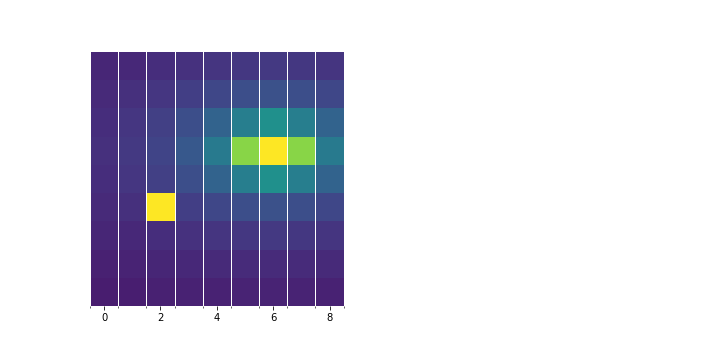

current q table [[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
i am called second
current q table [[1.20339966 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.  

current q table [[1.20339966 1.37565631 0.         0.         0.         0.
  0.         0.         0.        ]
 [2.58369675 1.20339966 1.37565631 0.         0.         0.
  0.         0.         0.        ]
 [1.20339966 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
i am called second
current q table [[1.20339966 1.37565631 0.         0.         0.         0.
  0.         0.         

current q table [[1.17167929 1.29554824 1.42475069 0.         0.         0.
  0.         0.         0.        ]
 [2.58369675 2.21717809 3.29816776 0.         0.         0.
  0.         0.         0.        ]
 [1.20339966 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
i am called second
current q table [[1.17167929 1.29554824 1.42475069 1.84858491 0.         0.
  0.         0.         

current q table [[1.17167929 1.29554824 2.82967523 3.05662535 1.63356644 2.39225658
  0.         0.         0.        ]
 [2.58369675 2.21717809 3.69869166 2.13712604 1.54497077 0.
  0.         0.         0.        ]
 [1.20339966 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
i am called second
current q table [[1.17167929 1.29554824 2.82967523 3.05662535 1.63356644 2.39225658
  0.    

current q table [[1.17167929 1.29554824 2.82967523 3.05662535 1.63356644 1.66666667
  0.         0.         0.        ]
 [2.58369675 2.21717809 3.69869166 2.13712604 2.39225658 1.63356644
  2.39225658 0.         0.        ]
 [1.20339966 0.         0.         0.         0.         7.02245556
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
i am called second
current q table [[1.17167929 1.29554824 2.82967523 3.05662535 1.63356644 1.6

current q table [[1.17167929 1.29554824 2.82967523 3.05662535 1.63356644 2.90817716
  2.90023311 1.66666667 1.63356644]
 [2.58369675 2.21717809 3.69869166 2.13712604 2.39225658 1.63356644
  2.39225658 0.         0.        ]
 [1.20339966 0.         0.         0.         0.         7.02245556
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
i am called second
current q table [[1.17167929 1.29554824 2.82967523 3.05662535 1.63356644 2.9

current q table [[ 1.17167929  1.29554824  2.82967523  3.05662535  1.63356644  7.02245556
   3.84378109  3.87084383  1.63356644]
 [ 2.58369675  2.21717809  3.69869166  2.13712604  2.39225658  9.9749413
   2.39225658  0.          0.        ]
 [ 1.20339966  0.          0.          0.          4.27425207 10.89925177
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          4.27425207
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am ca

current q table [[ 1.17167929  1.29554824  2.82967523  3.71440879  1.63356644  7.02245556
   3.84378109  3.87084383  1.63356644]
 [ 2.58369675  4.40053256  1.84858491  4.40053256  1.84858491  3.95524104
   2.39225658  0.          0.        ]
 [ 1.20339966  1.37565631  0.          0.          4.27425207 10.89925177
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          4.27425207
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am c

current q table [[ 1.17167929  1.29554824  2.82967523  5.56615443  1.63356644  7.02245556
   3.84378109  3.87084383  1.63356644]
 [ 2.58369675  4.40053256  1.84858491  2.40679931  3.17905379  3.95524104
   2.39225658  0.          0.        ]
 [ 1.20339966  1.37565631  0.          3.17905379 12.55768341 11.48597628
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          8.23754471  4.11877236
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am c

current q table [[2.21717809 1.04549879 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
i am called second
current q table [[2.21717809 4.72006105 0.         0.         0.         0.
  0.         0.         

current q table [[2.21717809 4.72006105 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         4.96273369 5.19298966 5.30609637 0.         0.
  0.         0.         0.        ]
 [0.         0.         2.05938618 1.90419384 0.         0.
  0.         0.         0.        ]
 [0.         0.         2.74584824 2.40679931 0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
i am called second
current q table [[2.21717809 4.72006105 0.         0.         0.         0.
  0.         0.         

current q table [[3.16700918 4.72006105 0.         0.         0.         0.
  0.         0.         0.        ]
 [1.0596846  4.96273369 5.19298966 5.30609637 0.         0.
  0.         0.         0.        ]
 [3.16700918 1.32392127 1.56475353 3.46932734 0.         0.
  0.         0.         0.        ]
 [0.         1.56475353 2.74584824 2.40679931 0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         2.74584824 0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
i am called second
current q table [[3.16700918 4.72006105 0.         0.         0.         0.
  0.         0.         

current q table [[3.16700918 4.72006105 0.         0.         0.         0.
  0.         0.         0.        ]
 [5.173297   4.96273369 5.19298966 5.30609637 0.         0.
  0.         0.         0.        ]
 [1.56475353 2.83672162 1.56475353 3.46932734 0.         0.
  0.         0.         0.        ]
 [1.64750894 1.37292412 2.74584824 2.40679931 0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         2.74584824 0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
i am called second
current q table [[3.16700918 4.72006105 0.         0.         0.         0.
  0.         0.         

current q table [[3.16700918 4.72006105 0.         0.         0.         0.
  0.         0.         0.        ]
 [5.173297   3.72066196 5.48434498 5.30609637 0.         0.
  0.         0.         0.        ]
 [1.56475353 4.71305457 1.58952689 3.46932734 0.         0.
  0.         0.         0.        ]
 [1.64750894 2.05938618 1.90419384 2.40679931 0.         0.
  0.         0.         0.        ]
 [0.         0.         1.58952689 2.74584824 0.         0.
  0.         0.         0.        ]
 [0.         0.         1.84858491 0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
i am called second
current q table [[3.16700918 4.72006105 0.         0.         0.         0.
  0.         0.         

current q table [[3.16700918 4.72006105 0.         0.         0.         0.
  0.         0.         0.        ]
 [5.173297   3.72066196 5.48434498 5.30609637 0.         0.
  0.         0.         0.        ]
 [1.56475353 4.71305457 1.58952689 3.46932734 0.         0.
  0.         0.         0.        ]
 [1.64750894 2.05938618 1.90419384 2.40679931 0.         0.
  0.         0.         0.        ]
 [0.         0.         1.58952689 2.74584824 0.         0.
  0.         0.         0.        ]
 [0.         0.         1.29554824 1.58952689 4.54054335 2.13712604
  0.         0.         0.        ]
 [0.         0.         1.42475069 1.84858491 0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
i am called second
current q table [[3.16700918 4.72006105 0.         0.         0.         0.
  0.         0. 

current q table [[ 3.16700918  4.72006105  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 5.173297    3.72066196  5.48434498  5.30609637  0.          0.
   0.          0.          0.        ]
 [ 1.56475353  4.71305457  1.58952689 12.72289318  0.          0.
   0.          0.          0.        ]
 [ 1.64750894  2.05938618  1.90419384  5.04348809  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          2.40679931  4.57501571  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          4.21209665  1.42475069  4.54054335  2.13712604
   0.          0.          0.        ]
 [ 0.          0.          1.58952689  1.29554824  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q t

current q table [[3.16700918 4.72006105 5.96672884 0.         0.         0.
  0.         0.         0.        ]
 [5.173297   6.43227044 6.35649852 5.30609637 0.         0.
  0.         0.         0.        ]
 [1.56475353 5.14733391 5.146675   3.78235404 2.40679931 0.
  0.         0.         0.        ]
 [1.64750894 2.05938618 1.90419384 5.04348809 0.         0.
  0.         0.         0.        ]
 [0.         0.         2.40679931 4.57501571 0.         0.
  0.         0.         0.        ]
 [0.         0.         4.21209665 1.42475069 4.54054335 2.13712604
  0.         0.         0.        ]
 [0.         0.         1.58952689 1.29554824 0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
i am called second
current q table [[3.16700918 4.72006105 7.29590616 0.         0.         0.
  0.         0. 

current q table [[3.16700918 4.72006105 7.29590616 0.         0.         0.
  0.         0.         0.        ]
 [5.173297   5.90790899 7.08591958 5.30609637 0.         0.
  0.         0.         0.        ]
 [1.56475353 5.81566685 4.14623084 3.78235404 2.40679931 0.
  0.         0.         0.        ]
 [1.64750894 5.90790899 1.64750894 2.05938618 0.         0.
  0.         0.         0.        ]
 [0.         0.         2.40679931 4.57501571 0.         0.
  0.         0.         0.        ]
 [0.         0.         4.21209665 1.42475069 4.54054335 2.13712604
  0.         0.         0.        ]
 [0.         0.         1.58952689 1.29554824 0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
i am called second
current q table [[3.16700918 4.72006105 7.29590616 0.         0.         0.
  0.         0. 

current q table [[3.16700918 4.72006105 7.29590616 0.         0.         0.
  0.         0.         0.        ]
 [6.50578993 7.76745782 7.08591958 5.30609637 0.         0.
  0.         0.         0.        ]
 [5.9999909  6.59796145 7.47671849 3.78235404 2.40679931 0.
  0.         0.         0.        ]
 [1.64750894 6.85329143 4.21209665 2.05938618 0.         0.
  0.         0.         0.        ]
 [0.         0.         2.40679931 4.57501571 0.         0.
  0.         0.         0.        ]
 [0.         0.         4.21209665 1.42475069 4.54054335 2.13712604
  0.         0.         0.        ]
 [0.         0.         1.58952689 1.29554824 0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
i am called second
current q table [[3.16700918 4.72006105 7.29590616 0.         0.         0.
  0.         0. 

current q table [[ 3.16700918  4.72006105  7.29590616  0.          0.          0.
   0.          0.          0.        ]
 [ 6.50578993  7.76745782  7.08591958  5.30609637  0.         14.28709428
   0.          0.          0.        ]
 [ 5.9999909   6.59796145  7.47671849  3.78235404  2.40679931 12.72289318
   0.          0.          0.        ]
 [ 1.64750894  6.85329143  7.34550937  4.11877236  3.17905379 13.00359405
   0.          0.          0.        ]
 [ 0.          0.          2.05938618  4.57501571  4.27425207  8.23754471
   0.          0.          0.        ]
 [ 0.          0.          4.21209665  1.42475069  4.54054335  2.13712604
   0.          0.          0.        ]
 [ 0.          0.          1.58952689  1.29554824  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]

current q table [[2.58984373 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
i am called second
current q table [[6.54052191 0.         0.         0.         0.         0.
  0.         0.         

current q table [[8.71752736 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [7.53741451 8.30150354 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
i am called second
current q table [[8.71752736 0.         0.         0.         0.         0.
  0.         0.         

current q table [[4.96802545 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [8.98055137 8.30150354 0.         0.         0.         0.
  0.         0.         0.        ]
 [8.47448065 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [1.32392127 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
i am called second
current q table [[4.96802545 8.35367995 0.         0.         0.         0.
  0.         0.         

current q table [[ 4.96802545  8.35367995  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 8.98055137  7.94337448  1.90419384  7.5370269   5.88121815  0.
   0.          0.          0.        ]
 [ 8.47448065  0.         12.07619813 14.63166106  4.55320691  0.
   0.          0.          0.        ]
 [ 1.32392127  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q table [[ 

current q table [[ 8.83205536  6.84043692  1.17167929  0.          0.          0.
   0.          0.          0.        ]
 [ 8.98055137  8.28188589  7.85262697  7.5370269   5.88121815  0.
   0.          0.          0.        ]
 [ 8.47448065  0.         12.07619813 14.63166106  4.55320691  0.
   0.          0.          0.        ]
 [ 1.32392127  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q table [[ 

current q table [[ 8.83205536 10.02384696 10.01710044  0.          0.          0.
   0.          0.          0.        ]
 [ 8.98055137  8.28188589 11.08210442  7.5370269   5.88121815  0.
   0.          0.          0.        ]
 [ 8.47448065  0.         12.07619813 14.63166106  4.55320691  0.
   0.          0.          0.        ]
 [ 1.32392127  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q table [[ 

current q table [[ 8.83205536 10.02384696 10.01710044  0.          0.          0.
   0.          0.          0.        ]
 [ 8.98055137  8.28188589  8.24560631  6.60685183 15.50355897  0.
   0.          0.          0.        ]
 [ 8.47448065  0.         10.01192626 15.88531254 12.28974103  0.
   0.          0.          0.        ]
 [ 1.32392127  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q table [[ 

current q table [[ 8.83205536 10.02384696 10.01710044  0.          0.          0.
   0.          0.          0.        ]
 [ 8.98055137  8.28188589  8.24560631 14.81377601 18.36579279  0.
   5.          0.          0.        ]
 [ 8.47448065  0.         10.01192626 14.43943016 15.60033716  5.
   2.5         0.          0.        ]
 [ 1.32392127  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q table [[ 

current q table [[9.53144424 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [7.36496632 9.51672046 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
i am called second
current q table [[ 9.53144424  0.          0.          0.          0.          0.
   0.          0. 

current q table [[ 9.53144424  0.         11.69744096  0.          0.          0.
   0.          0.          0.        ]
 [ 8.8420398  10.5780606  11.09255775  0.          0.          0.
   0.          0.          0.        ]
 [ 6.89882673 11.07907731  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q table [[ 

current q table [[ 9.53144424 11.49145458 11.69744096  0.          0.          0.
   0.          0.          0.        ]
 [ 9.26815027 10.79032862 11.09255775  0.          0.          0.
   0.          0.          0.        ]
 [11.05166692 14.59311089 13.3719021   0.          0.          0.
   0.          0.          0.        ]
 [ 7.76452656  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q table [[ 

current q table [[ 9.53144424 11.49145458 11.69744096  0.          0.          0.
   0.          0.          0.        ]
 [ 9.26815027 13.89605866 11.89388538  0.          0.          0.
   0.          0.          0.        ]
 [11.05166692 10.95837242 11.70435066  0.          0.          0.
   0.          0.          0.        ]
 [ 7.76452656  7.2739643   1.90419384  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q table [[ 

current q table [[ 9.53144424 11.49145458 11.69744096  0.          0.          0.
   0.          0.          0.        ]
 [ 9.26815027 13.89605866 11.89388538  0.          0.          0.
   0.          0.          0.        ]
 [11.05166692 10.95837242 11.70435066  0.          0.          0.
   0.          0.          0.        ]
 [ 1.32392127  7.2739643   1.90419384  0.          0.          0.
   0.          0.          0.        ]
 [ 4.25714103  3.27783088  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.32392127  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q table [[ 

current q table [[ 9.53144424 11.49145458 11.69744096  0.          0.          0.
   0.          0.          0.        ]
 [ 9.26815027 13.89605866 11.89388538  0.          0.          0.
   0.          0.          0.        ]
 [11.05166692 10.95837242 11.70435066  0.          0.          0.
   0.          0.          0.        ]
 [ 1.32392127  7.2739643   1.90419384  0.          0.          0.
   0.          0.          0.        ]
 [ 4.25714103  1.90419384  5.88381125  1.84858491  0.          0.
   0.          0.          0.        ]
 [ 1.32392127  0.          0.          5.86892389  1.54497077  6.42404904
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.19612829  0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.23585241  1.25
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q

current q table [[ 9.53144424 11.49145458 11.69744096  0.          0.          0.
   0.          0.          0.        ]
 [ 9.26815027 13.89605866 11.89388538  0.          0.          0.
   0.          0.          0.        ]
 [11.05166692 10.95837242 11.70435066  0.          0.          0.
   0.          0.          0.        ]
 [ 1.32392127  7.2739643   1.90419384  0.          0.          0.
   0.          0.          0.        ]
 [ 4.25714103  1.90419384  5.88381125  1.84858491  0.          0.
   0.          0.          0.        ]
 [ 1.32392127  0.          0.          5.86892389  1.54497077  1.63356644
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.19612829  1.66666667
   1.63356644  2.39225658  0.        ]
 [ 0.          0.          0.          0.          1.23585241  1.63356644
   1.23585241  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   1.25        0.          0.        ]]
i am called se

current q table [[ 9.53144424 11.49145458 11.69744096  0.          0.          0.
   0.          0.          0.        ]
 [ 9.26815027 13.89605866 11.89388538  0.          0.          0.
   0.          0.          0.        ]
 [11.05166692 10.95837242 11.70435066  0.          0.          0.
   0.          0.          0.        ]
 [ 1.32392127  7.2739643   1.90419384  0.          0.          0.
   0.          0.          0.        ]
 [ 4.25714103  1.90419384  5.88381125  1.84858491  0.          0.
   0.          0.          0.        ]
 [ 1.32392127  0.          0.          5.86892389  1.54497077  1.63356644
   0.          3.45168145  2.39225658]
 [ 0.          0.          0.          0.          1.19612829  1.66666667
   1.63356644  3.16918655  1.19612829]
 [ 0.          0.          0.          0.          1.23585241  1.63356644
   1.23585241  0.99271203  1.23585241]
 [ 0.          0.          0.          0.          0.          0.
   1.25        0.97176849  0.        ]]
i am called se

current q table [[ 9.53144424 11.49145458 11.69744096  0.          0.          0.
   0.          0.          0.        ]
 [ 9.26815027 13.89605866 11.89388538  0.          0.          0.
   0.          0.          0.        ]
 [11.05166692 10.95837242 11.70435066  0.          0.          0.
   0.          0.          0.        ]
 [ 1.32392127  7.2739643   1.90419384  0.          0.          0.
   0.          0.          0.        ]
 [ 4.25714103  1.90419384  5.88381125  1.84858491  0.          0.
   0.          3.17905379  0.        ]
 [ 1.32392127  0.          0.          5.86892389  1.54497077  1.63356644
   0.          4.27425207  2.39225658]
 [ 0.          0.          0.          0.          1.19612829  1.66666667
   1.63356644  5.01553448  1.19612829]
 [ 0.          0.          0.          0.          1.23585241  1.63356644
   1.23585241  1.63356644  0.97176849]
 [ 0.          0.          0.          0.          0.          0.
   1.25        1.23585241  0.99271203]]
i am called se

current q table [[ 9.53144424 11.49145458 11.69744096  0.          0.          0.
   0.          0.          0.        ]
 [ 9.26815027 13.89605866 11.89388538  0.          0.          0.
   0.          0.          0.        ]
 [11.05166692 10.95837242 11.70435066  0.          0.          0.
   0.          0.          0.        ]
 [ 1.32392127  7.2739643   1.90419384  0.          0.          0.
   0.          0.          0.        ]
 [ 4.25714103  1.90419384  5.88381125  1.84858491  0.          0.
   0.          3.17905379  2.13712604]
 [ 1.32392127  0.          0.          5.86892389  1.54497077  2.5
   2.39225658  5.80899565  5.64068816]
 [ 0.          0.          0.          0.          1.19612829  1.66666667
   1.25        1.66666667  1.19612829]
 [ 0.          0.          0.          0.          1.23585241  1.63356644
   1.23585241  1.63356644  0.97176849]
 [ 0.          0.          0.          0.          0.          0.
   1.25        1.23585241  0.99271203]]
i am called second
cu

current q table [[ 9.53144424 11.49145458 11.69744096  0.          0.          0.
   0.          0.          0.        ]
 [ 9.26815027 13.89605866 11.89388538  0.          0.          0.
   0.          0.          0.        ]
 [11.05166692 10.95837242 11.70435066  0.          0.          0.
   0.          0.          0.        ]
 [ 1.32392127  7.2739643   1.90419384  0.          0.          0.
   0.          0.          0.        ]
 [ 4.25714103  1.90419384  5.88381125  1.84858491  0.          0.
   0.          3.17905379  2.13712604]
 [ 1.32392127  0.          0.          5.86892389  1.54497077  2.5
   2.39225658  5.80899565  5.64068816]
 [ 0.          0.          0.          0.          1.19612829  1.66666667
   1.25        1.66666667  1.19612829]
 [ 0.          0.          0.          0.          1.23585241  1.63356644
   1.23585241  3.23570945  1.54497077]
 [ 0.          0.          0.          0.          0.          0.
   1.25        1.88082599  3.35591516]]
i am called second
cu

current q table [[ 9.53144424 11.49145458 11.69744096  0.          0.          0.
   0.          0.          0.        ]
 [ 9.26815027 13.89605866 11.89388538  0.          0.          0.
   0.          0.          0.        ]
 [11.05166692 10.95837242 11.70435066  0.          0.          0.
   0.          0.          0.        ]
 [ 1.32392127  7.2739643   1.90419384  0.          0.          0.
   0.          4.11877236  3.17905379]
 [ 4.25714103  1.90419384  5.88381125  1.84858491  0.          0.
   0.          8.23754471  2.13712604]
 [ 1.32392127  0.          0.          5.86892389  1.54497077  2.5
   2.39225658  6.69033295  5.64068816]
 [ 0.          0.          0.          0.          1.19612829  1.66666667
   1.25        7.33174886  1.63356644]
 [ 0.          0.          0.          0.          1.23585241  1.63356644
   1.23585241  5.44537265  1.54497077]
 [ 0.          0.          0.          0.          0.          0.
   1.25        1.88082599  3.35591516]]
i am called second
cu

current q table [[8.85372517 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
i am called second
current q table [[11.43725999  0.          0.          0.          0.          0.
   0.          0. 

current q table [[11.95830091 13.95982055  5.93601297 14.03731597  0.          0.
   0.          0.          0.        ]
 [ 0.         12.56751356 12.02510276  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q table [[1

current q table [[11.95830091 13.95982055  5.93601297 14.03731597  0.          0.
   0.          0.          0.        ]
 [ 0.         12.56751356 12.02510276 18.4712855   0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.         18.44214351 17.89018226  0.
   0.          0.          0.        ]
 [ 0.         12.2890995   6.83747096 10.37590054 10.63412105  0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q table [[1

current q table [[11.95830091 13.95982055  5.93601297 14.03731597  0.          0.
   0.          0.          0.        ]
 [ 0.         12.56751356 12.02510276 18.4712855   0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.         18.44214351 17.89018226  0.
   0.          0.          0.        ]
 [12.85516769 10.90342283  6.83747096 10.37590054 10.63412105  0.
   0.          0.          0.        ]
 [ 1.37292412  4.95013037  1.56475353  0.          0.          0.
   0.          0.          0.        ]
 [ 4.55934845  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q table [[1

current q table [[11.95830091 13.95982055  5.93601297 14.03731597  0.          0.
   0.          0.          0.        ]
 [ 0.         12.56751356 12.33151427 18.4712855   0.          0.
   0.          0.          0.        ]
 [14.55290049 16.19214078 12.75156974 18.44214351 17.89018226  0.
   0.          0.          0.        ]
 [12.85516769 15.08521218  6.83747096 10.37590054 10.63412105  0.
   0.          0.          0.        ]
 [ 1.37292412  1.64750894  1.56475353  0.          0.          0.
   0.          0.          0.        ]
 [ 4.55934845  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q table [[1

current q table [[10.58100535 12.15146964 13.43740855  1.29554824  1.42475069  0.
   0.          0.          0.        ]
 [13.97297144 12.56751356 12.33151427 18.4712855   0.          0.
   0.          0.          0.        ]
 [13.27707415 16.19214078 12.75156974 18.44214351 17.89018226  0.
   0.          0.          0.        ]
 [12.85516769 15.08521218  6.83747096 10.37590054 10.63412105  0.
   0.          0.          0.        ]
 [ 1.37292412  1.64750894  1.56475353  0.          0.          0.
   0.          0.          0.        ]
 [ 4.55934845  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q table [[1

current q table [[10.58100535 13.25363848 12.62188515  1.29554824  1.42475069  0.
   0.          0.          0.        ]
 [15.11793923 13.58917591 12.33151427 18.4712855   0.          0.
   0.          0.          0.        ]
 [13.27707415 16.19214078 12.75156974 18.44214351 17.89018226  0.
   0.          0.          0.        ]
 [12.85516769 15.08521218  6.83747096 10.37590054 10.63412105  0.
   0.          0.          0.        ]
 [ 1.37292412  1.64750894  1.56475353  0.          0.          0.
   0.          0.          0.        ]
 [ 4.55934845  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q table [[1

current q table [[10.58100535 14.50522574 15.64058764  1.29554824  1.42475069  0.
   0.          0.          0.        ]
 [15.11793923 13.58917591 14.61677028 18.4712855   0.          0.
   0.          0.          0.        ]
 [13.27707415 17.09826301 15.59428947 18.44214351 17.89018226  0.
   0.          0.          0.        ]
 [12.85516769 15.08521218  6.83747096 10.37590054 10.63412105  0.
   0.          0.          0.        ]
 [ 1.37292412  1.64750894  1.56475353  0.          0.          0.
   0.          0.          0.        ]
 [ 4.55934845  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q table [[1

current q table [[10.58100535 15.82433034 16.17209305 10.735735   14.22678286  0.
   0.          0.          0.        ]
 [15.11793923 14.67915018 17.16616617 18.63045855  2.78648126  0.
   0.          0.          0.        ]
 [13.27707415 17.09826301 15.59428947 18.44214351 17.89018226  0.
   0.          0.          0.        ]
 [12.85516769 15.08521218  6.83747096 10.37590054 10.63412105  0.
   0.          0.          0.        ]
 [ 1.37292412  1.64750894  1.56475353  0.          0.          0.
   0.          0.          0.        ]
 [ 4.55934845  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q table [[1

current q table [[10.58100535 15.82433034 17.55232642 13.58633895 14.22678286  0.
   0.          0.          0.        ]
 [15.11793923 16.83141052 16.95782275 18.63045855  2.78648126  0.
   0.          0.          0.        ]
 [13.27707415 17.09826301 19.03361681 19.82821025 20.64446424  0.
   0.          0.          0.        ]
 [12.85516769 15.08521218  6.83747096 10.37590054  7.07717168  0.
   0.          0.          0.        ]
 [ 1.37292412  1.64750894  1.56475353  0.          0.          0.
   0.          0.          0.        ]
 [ 4.55934845  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q table [[1

current q table [[1.05810054e+01 1.58243303e+01 1.75523264e+01 1.35863390e+01
  1.42267829e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.51179392e+01 1.68314105e+01 1.69578228e+01 1.86304586e+01
  2.78648126e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.32770741e+01 1.70982630e+01 1.90336168e+01 1.98282102e+01
  2.06444642e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.28551677e+01 1.50852122e+01 6.83747096e+00 1.03759005e+01
  7.07717168e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.37292412e+00 1.64750894e+00 1.56475353e+00 0.00000000e+00
  1.05347861e+01 2.84626375e+15 8.18245132e+00 0.00000000e+00
  0.00000000e+00]
 [4.55934845e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 7.27453385e+00 8.18245132e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0000

current q table [[1.05810054e+01 1.58243303e+01 1.75523264e+01 1.35863390e+01
  1.42267829e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.51179392e+01 1.68314105e+01 1.69578228e+01 1.86304586e+01
  2.78648126e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.32770741e+01 1.70982630e+01 1.90336168e+01 1.98282102e+01
  2.06444642e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.28551677e+01 1.50852122e+01 6.83747096e+00 1.03759005e+01
  7.07717168e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.37292412e+00 1.64750894e+00 1.56475353e+00 0.00000000e+00
  1.05347861e+01 2.84626375e+15 8.18245132e+00 0.00000000e+00
  0.00000000e+00]
 [4.55934845e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.45402827e+00 7.28143364e+00 7.27453385e+00 8.18245132e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.13537613e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0000

current q table [[1.05810054e+01 1.58243303e+01 1.75523264e+01 1.35863390e+01
  1.42267829e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.51179392e+01 1.68314105e+01 1.69578228e+01 1.86304586e+01
  2.78648126e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.32770741e+01 1.70982630e+01 1.90336168e+01 1.98282102e+01
  2.06444642e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.28551677e+01 1.50852122e+01 6.83747096e+00 1.03759005e+01
  7.07717168e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.37292412e+00 1.64750894e+00 1.56475353e+00 0.00000000e+00
  1.05347861e+01 2.84626375e+15 8.18245132e+00 0.00000000e+00
  0.00000000e+00]
 [4.55934845e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.45402827e+00 7.28143364e+00 7.27453385e+00 8.18245132e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.13537613e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0000

current q table [[1.05810054e+01 1.58243303e+01 1.75523264e+01 1.35863390e+01
  1.42267829e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.51179392e+01 1.68314105e+01 1.69578228e+01 1.86304586e+01
  2.78648126e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.32770741e+01 1.70982630e+01 1.90336168e+01 1.98282102e+01
  2.06444642e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.28551677e+01 1.50852122e+01 6.83747096e+00 1.03759005e+01
  7.07717168e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.37292412e+00 1.64750894e+00 1.56475353e+00 0.00000000e+00
  1.05347861e+01 2.84626375e+15 8.18245132e+00 0.00000000e+00
  0.00000000e+00]
 [4.55934845e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.45402827e+00 7.28143364e+00 7.27453385e+00 8.18245132e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.13537613e+00 7.92614615e+00 1.63356644e+00 2.90817716e+00
  0.0000

current q table [[15.35549468 17.54107273  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q table [[1

current q table [[15.35549468 17.54107273 18.00736389 14.19547859  2.13712604  0.
   0.          0.          0.        ]
 [ 0.          0.         19.07124967 12.65770097  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
i am called second
current q table [[1

current q table [[1.53554947e+01 1.75410727e+01 1.80073639e+01 1.41954786e+01
  2.13712604e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90712497e+01 1.26577010e+01
  2.19061944e+01 2.16316045e+15 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.80207276e+01 1.84313292e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.16316045e+15 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.41551650e+15 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0000

current q table [[1.53554947e+01 1.75410727e+01 1.80073639e+01 1.41954786e+01
  2.13712604e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90712497e+01 1.26577010e+01
  2.19061944e+01 1.91494568e+01 1.97280233e+15 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.80207276e+01 2.84626375e+15 2.16316045e+15 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.16316045e+15 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.41551650e+15 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0000

current q table [[1.53554947e+01 1.75410727e+01 1.80073639e+01 1.84454796e+01
  1.47737208e+01 1.54497077e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90712497e+01 1.76899053e+01
  1.64400194e+15 6.97063267e+00 1.97280233e+15 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.80207276e+01 2.84626375e+15 2.16316045e+15 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.16316045e+15 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.41551650e+15 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0000

current q table [[1.53554947e+01 1.75410727e+01 1.80073639e+01 1.93271124e+01
  1.47737208e+01 1.54497077e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90712497e+01 2.06891363e+01
  1.64400194e+15 6.97063267e+00 1.97280233e+15 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.21986779e+01
  2.11953206e+01 2.84626375e+15 2.16316045e+15 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.19651148e+01 2.16316045e+15 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.78901823e+01 3.41551650e+15 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0000

current q table [[1.53554947e+01 1.75410727e+01 1.80073639e+01 1.93271124e+01
  1.47737208e+01 1.54497077e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90712497e+01 2.06891363e+01
  1.64400194e+15 6.97063267e+00 1.97280233e+15 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.16445667e+01 1.89620928e+01
  2.21442867e+01 2.84626375e+15 2.16316045e+15 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.30489513e+01 1.50200616e+01 0.00000000e+00
  3.17905379e+00 2.16316045e+15 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.31122702e+01 0.00000000e+00 0.00000000e+00
  1.78901823e+01 3.41551650e+15 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0000

current q table [[1.53554947e+01 1.75410727e+01 1.80073639e+01 1.93271124e+01
  1.47737208e+01 1.54497077e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90712497e+01 2.06891363e+01
  1.64400194e+15 6.97063267e+00 1.97280233e+15 0.00000000e+00
  0.00000000e+00]
 [1.20142530e+01 0.00000000e+00 1.16445667e+01 1.89620928e+01
  2.21442867e+01 2.84626375e+15 2.16316045e+15 0.00000000e+00
  0.00000000e+00]
 [1.60753020e+01 1.55205756e+01 1.19796874e+01 0.00000000e+00
  3.17905379e+00 2.16316045e+15 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.31122702e+01 0.00000000e+00 0.00000000e+00
  1.78901823e+01 3.41551650e+15 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0000

current q table [[1.53554947e+01 1.75410727e+01 1.80073639e+01 1.93271124e+01
  1.47737208e+01 1.54497077e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90712497e+01 2.06891363e+01
  1.64400194e+15 6.97063267e+00 1.97280233e+15 0.00000000e+00
  0.00000000e+00]
 [1.20142530e+01 0.00000000e+00 1.16445667e+01 1.89620928e+01
  2.21442867e+01 2.84626375e+15 2.16316045e+15 0.00000000e+00
  0.00000000e+00]
 [1.60753020e+01 1.55205756e+01 1.19796874e+01 5.88381125e+00
  3.17905379e+00 2.16316045e+15 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.39343552e+01 5.08015781e+00 1.90419384e+00
  1.78901823e+01 3.41551650e+15 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.37565631e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0000

KeyboardInterrupt: 

In [78]:
# rewards table
R = np.array(reward_matrix)

# can we avoid going to same state? by tracking it ?

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.001             # Exponential decay rate for exploration prob

exploration = Exploration(epsilon, max_epsilon, min_epsilon, decay_rate)

interactive = True
max_number_of_episodes = 10
env = TwoParaEnv(R)
agent = QLearningAgent(range(env.action_space.n))
run = Run(env, agent)
run.run_qlearning(exploration, max_number_of_episodes, interactive)
# color gradients for the visual appealing to look the movements.
# boundary : choose another action instead of remain at the same state (sample from the actions again)
# looking at the gradients
# normalize loss/ q values
# 

<IPython.core.display.Javascript object>


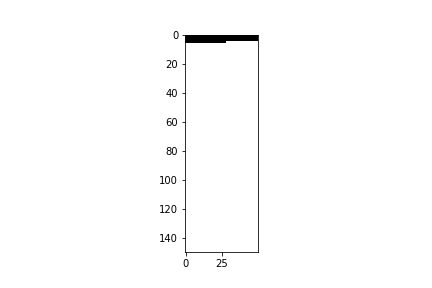

In [45]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

nx = 150
ny = 50

fig = plt.figure()
data = np.zeros((nx, ny))
im = plt.imshow(data, cmap="gist_gray_r", vmin=0, vmax=1)


def init():
    im.set_data(np.zeros((nx, ny)))


def animate(i):
    xi = i // ny
    yi = i % ny
    data[xi, yi] = 1
    im.set_data(data)
    return im


anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=nx * ny, interval=50
)

